## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

## Import libraries and load the dataset

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

from wordcloud import WordCloud

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('../data/train.csv')

#### Note
Since there was no designated test dataset for this project, we will use only the `train.csv` file - we will split it into train and test datasets using `Scikit-Learn`

### Exploration

In [4]:
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [5]:
df.shape

(404290, 6)

In [6]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
df[df.isna().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [8]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop('id', axis=1, inplace=True)
y = df['is_duplicate']

In [9]:
df[df['is_duplicate'] == 1]

,qid1,qid2,question1,question2,is_duplicate
5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
...,...,...,...,...,...
404277,537922,537923,What are some outfit ideas to wear to a frat p...,What are some outfit ideas wear to a frat them...,1
404278,99131,81495,Why is Manaphy childish in Pokémon Ranger and ...,Why is Manaphy annoying in Pokemon ranger and ...,1
404279,1931,16773,How does a long distance relationship work?,How are long distance relationships maintained?,1
404281,537926,537927,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...,1


In [10]:
df[df['is_duplicate'] == 0]

,qid1,qid2,question1,question2,is_duplicate
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...
404280,537924,537925,What do you think of the removal of the MagSaf...,What will the CPU upgrade to the 2016 Apple Ma...,0
404282,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404284,537928,537929,What is one coin?,What's this coin?,0
404285,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [11]:
df['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

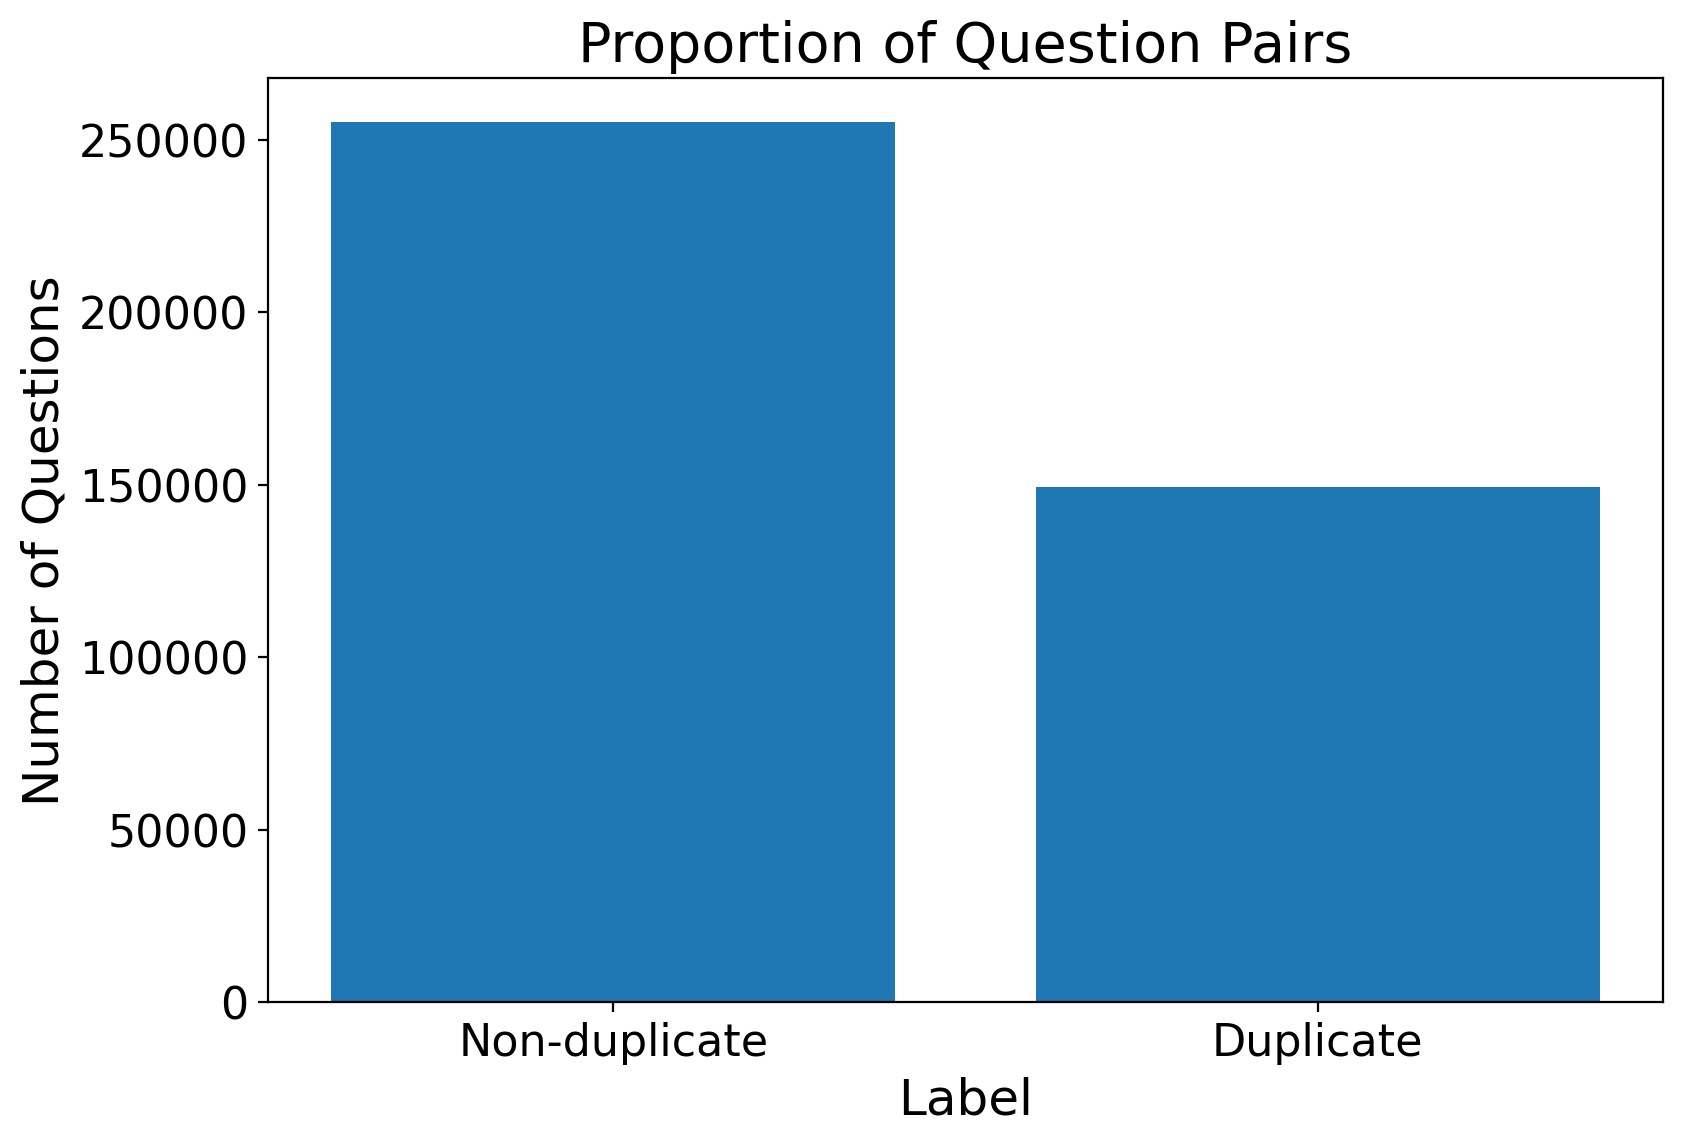

In [12]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(9,6))

# create bar chart
fig = plt.bar(x=['Non-duplicate', 'Duplicate'], height=df['is_duplicate'].value_counts())

# customize bar chart
ax.set_xticks([0, 1])
ax.set_title('Proportion of Question Pairs', fontsize=20)
ax.set_ylabel('Number of Questions', fontsize=18)
ax.set_xlabel('Label', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

# show plot
plt.show()

In [13]:
df.dtypes

qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [14]:
# Create columns with character length 
df['q1_char_length'] = df['question1'].str.len()
df['q2_char_length'] = df['question2'].str.len()

In [15]:
# Check the mean character length
df[['q1_char_length', 'q2_char_length']].mean()

q1_char_length    59.536997
q2_char_length    60.108507
dtype: float64

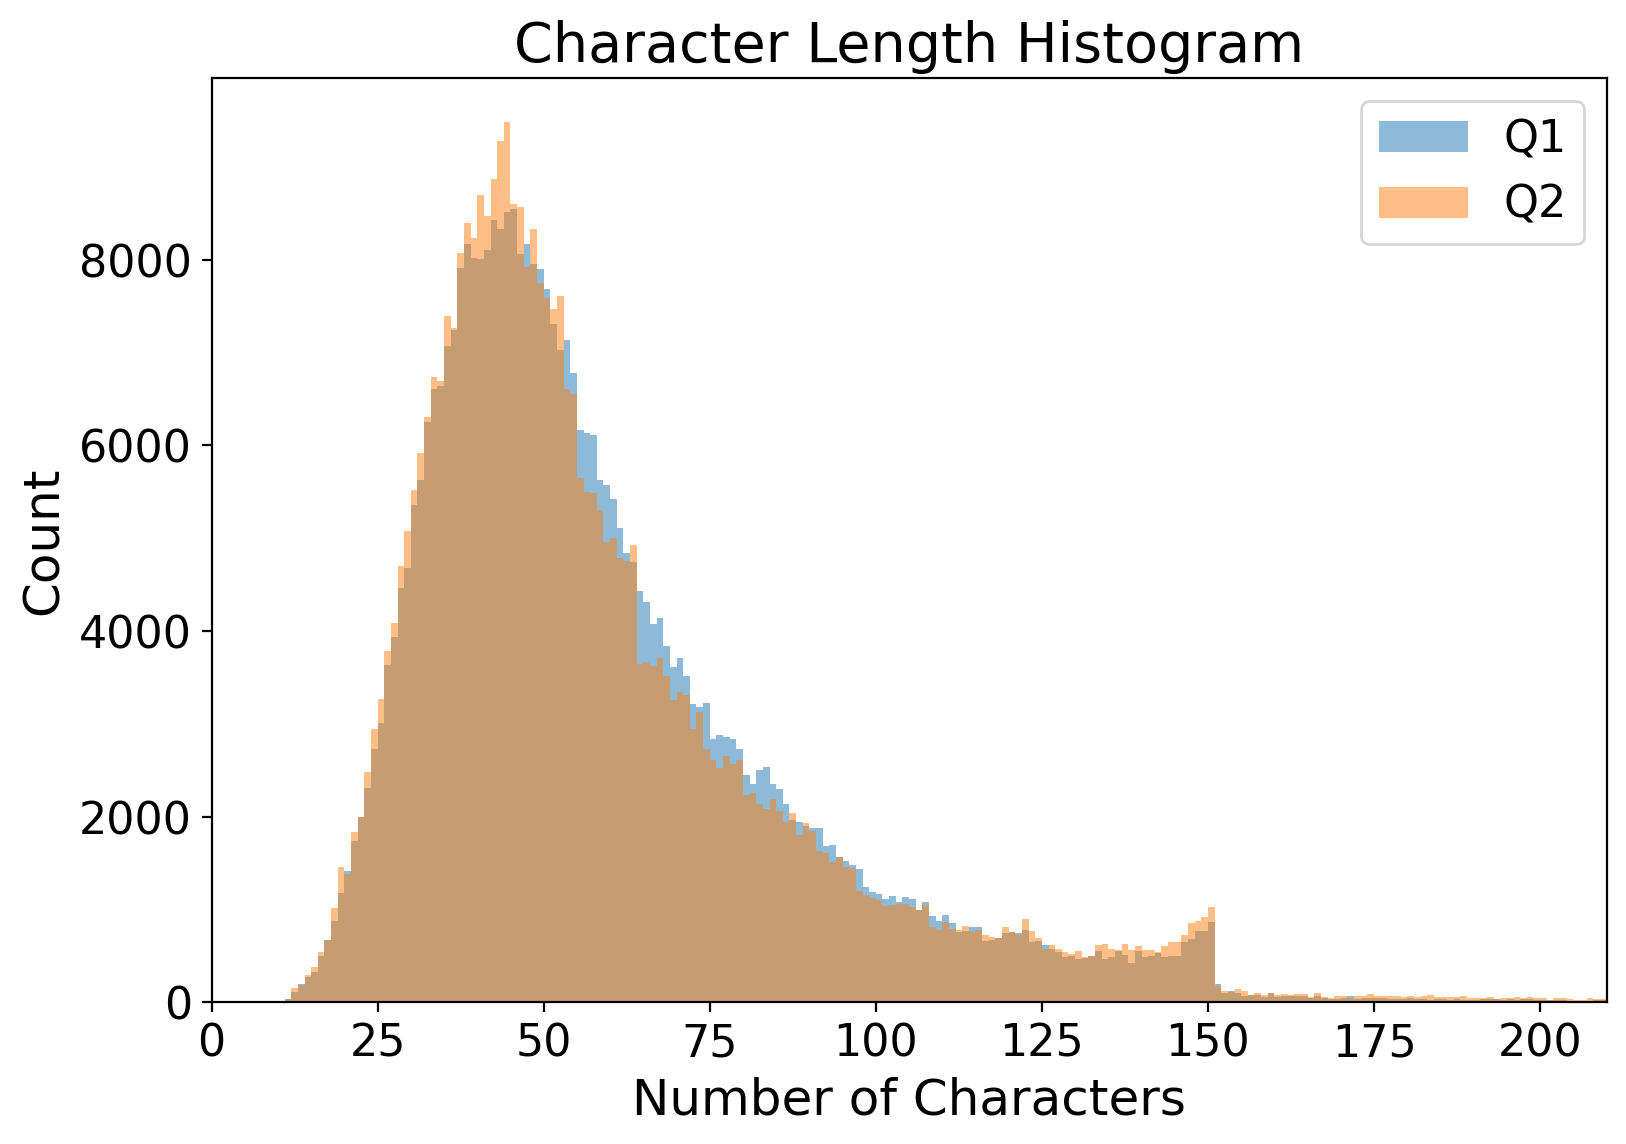

In [16]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(9,6))

# create bar chart
plt.hist(df['q1_char_length'], bins=250, alpha=0.5, range=[0, 250], label='Q1')
plt.hist(df['q2_char_length'], bins=250, alpha=0.5, range=[0, 250], label='Q2')

# customize bar chart
ax.set_title('Character Length Histogram', fontsize=20)
ax.set_ylabel('Count', fontsize=18)
ax.set_xlabel('Number of Characters', fontsize=18)
ax.set_xlim([0, 210])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)

# show plot
plt.show()

In [17]:
# Repeated questions
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 537929
Number of questions getting repeated 111778


In [18]:
!pip install wordcloud

(-0.5, 1439.5, 1079.5, -0.5)

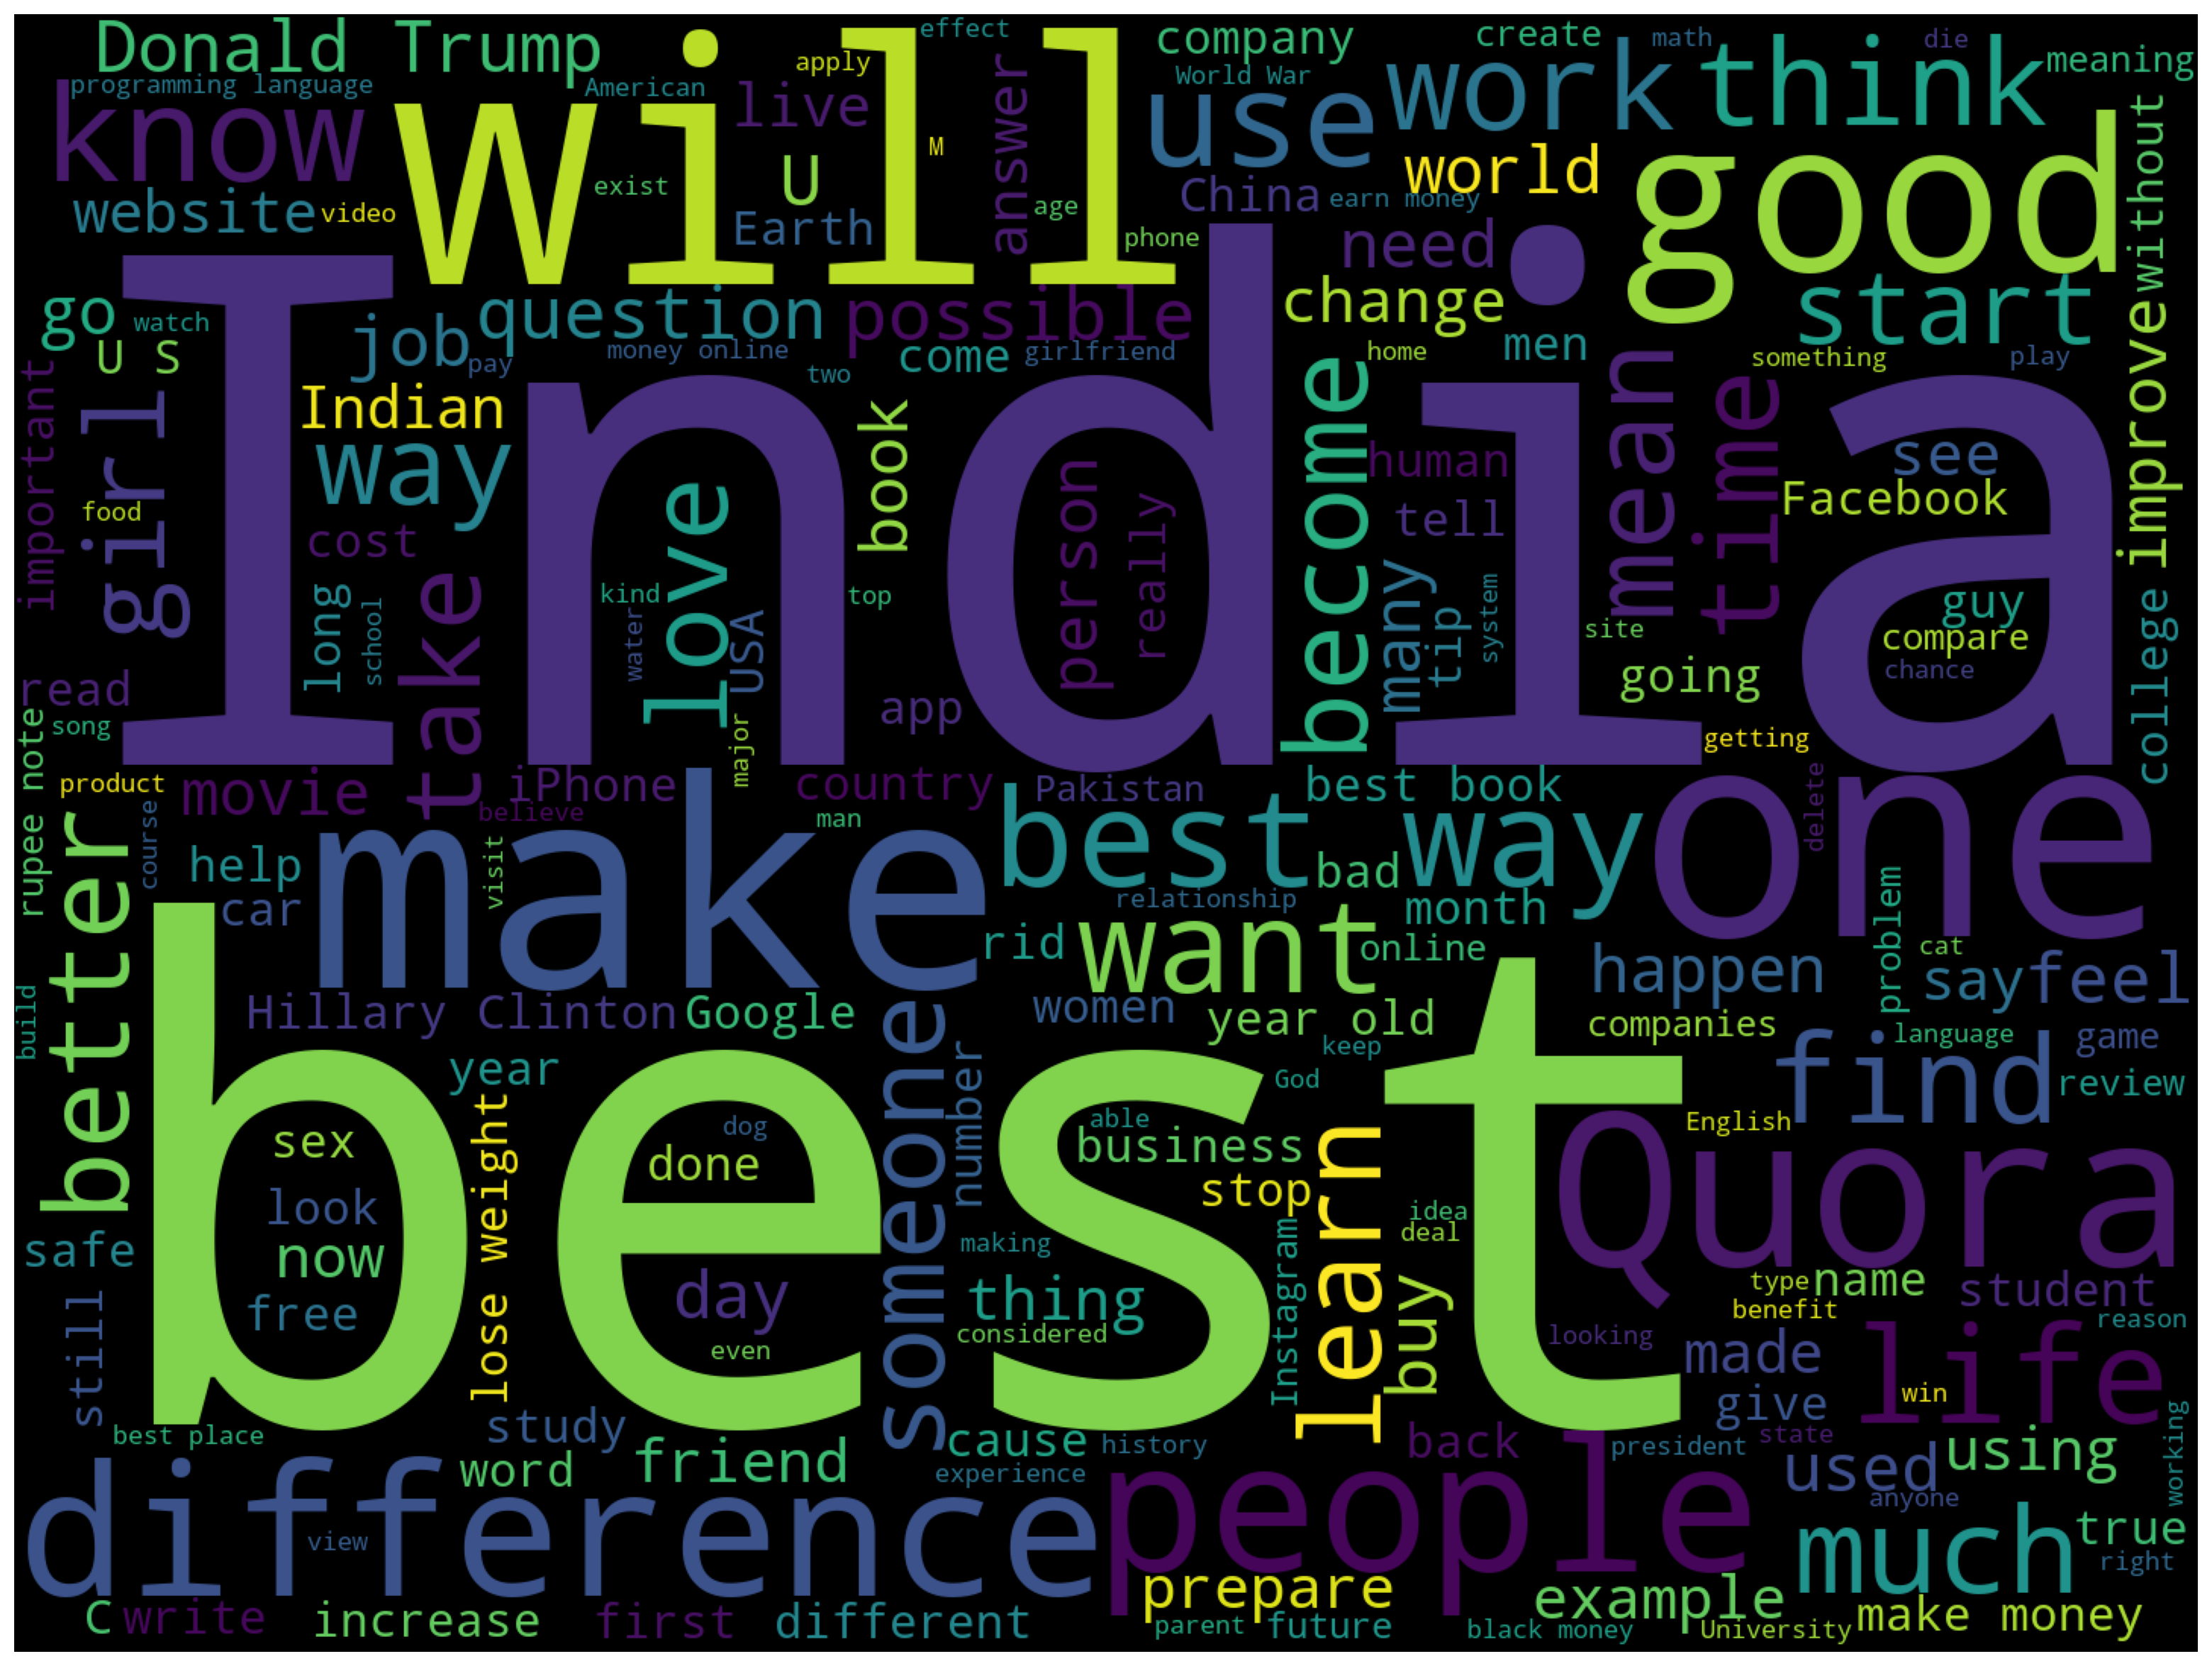

In [19]:
# Let's look at the most frequent words using wordcloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(df['question2'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [19]:
# Drop off after 150 characters - possibly size limit at Quora?

In [20]:
#len(df['question1'].tolist() + df['question2'].tolist())

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [11]:
def preprocess(text):
    # make lower case 
    text = text.lower()
    
    # tokenize
    text = word_tokenize(text)
    
    # remove stopwords
    stoppers = stopwords.words('english')
    text = [word for word in text if word not in stoppers]
    
    # remove punctuation
    text = [word for word in text if word.isalpha()]
    
    # lemmatize
    lemm = WordNetLemmatizer()
    text = [lemm.lemmatize(words) for words in text]
    
    return text

In [12]:
df['q1_token'] = df['question1'].apply(preprocess)
df['q2_token'] = df['question2'].apply(preprocess)

In [23]:
df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_char_length,q2_char_length,q1_token,q2_token
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]"
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,"[story, kohinoor, diamond]","[would, happen, indian, government, stole, koh..."
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]"
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,"[mentally, lonely, solve]","[find, remainder, math, divided]"
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]"


In [24]:
#from nltk.stem import WordNetLemmatizer

#def lemmatize(text):
#    lemm = WordNetLemmatizer()
#    text = [lemm.lemmatize(words_sent) for words_sent in text]
#    return text

In [25]:
#df['q2_token'].apply(lambda x: lemmatize(x))

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [13]:
# Build baseline model: word count
df['q1_n_words'] = df['q1_token'].apply(len)
df['q2_n_words'] = df['q2_token'].apply(len)

In [14]:
df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_char_length,q2_char_length,q1_token,q2_token,q1_n_words,q2_n_words
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",7,6
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,"[story, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",3,8
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",6,5
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,"[mentally, lonely, solve]","[find, remainder, math, divided]",3,4
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",10,5


In [8]:
# Using tf-idf
vectorizer = TfidfVectorizer()

In [15]:
df['q1_clean'] = df['q1_token'].apply(lambda x: ' '.join(x))
df['q2_clean'] = df['q2_token'].apply(lambda x: ' '.join(x))

In [10]:
df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_token,q2_token,q1_n_words,q2_n_words,q1_clean,q2_clean
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",7,6,step step guide invest share market india,step step guide invest share market
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",3,8,story kohinoor diamond,would happen indian government stole kohinoor ...
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",6,5,increase speed internet connection using vpn,internet speed increased hacking dns
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[find, remainder, math, divided]",3,4,mentally lonely solve,find remainder math divided
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",10,5,one dissolve water quikly sugar salt methane c...,fish would survive salt water


In [31]:
# Run TF-IDF on each question
q1_tfidf = vectorizer.fit_transform(df['q1_clean'])
#vocab1 = vectorizer.vocabulary_
q2_tfidf = vectorizer.fit_transform(df['q2_clean'])
#vocab2 = vectorizer.vocabulary_

In [32]:
#vocab1_keys = list(vocab1.keys())

In [33]:
#vocab1_vals = list(vocab1.values())

In [34]:
#idx_sorted = np.argsort(np.array(vocab1_vals))

In [35]:
#[vocab1_keys[i] for i in idx_sorted]

In [36]:
from scipy.sparse import hstack

q_tfidf = hstack((q1_tfidf, q2_tfidf))

In [37]:
q_tfidf.shape

(404287, 104703)

In [38]:
# Matrix is too large, let's try using SVD
from sklearn.decomposition import TruncatedSVD

# Instantiate it 
svd = TruncatedSVD(n_components=200)

# Fit to our matrix
q_svd = svd.fit_transform(q_tfidf)

In [39]:
q_svd.shape

(404287, 200)

In [40]:
# Need to calculate similarity between q1_tfidf and q2_tfidf
#from numpy import dot
#from numpy.linalg import norm

#cos_sim = (q1_tfidf @ q2_tfidf.T) / (norm(q1_tfidf)*norm(q2_tfidf))

In [41]:
#def cosine_sim(q1, q2):
#    try:
#        tfidf = vectorizer.fit_transform([q1, q2])
        #print(text1)
        #print(text2)
#    except Exception:
#        print(text1)
#        print(text2)
    
#    return ((tfidf * tfidf.T).A)[0,1]

In [42]:
#my_list = []

#for index, row in df.iloc[0:100].iterrows():
#    cosine_ = cosine_sim(row['q1_clean'], row['q2_clean'])
#    my_list.append(cosine_)

In [43]:
#my_list

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [44]:
df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_char_length,q2_char_length,q1_token,q2_token,q1_n_words,q2_n_words,q1_clean,q2_clean
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",7,6,step step guide invest share market india,step step guide invest share market
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,"[story, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",3,8,story kohinoor diamond,would happen indian government stole kohinoor ...
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",6,5,increase speed internet connection using vpn,internet speed increased hacking dns
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,"[mentally, lonely, solve]","[find, remainder, math, divided]",3,4,mentally lonely solve,find remainder math divided
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",10,5,one dissolve water quikly sugar salt methane c...,fish would survive salt water


### Logistic Regression + Word Counts

In [176]:
# Select our target and features
X = df[['q1_n_words', 'q2_n_words']]
y = df['is_duplicate']

In [177]:
# split data into train and test 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [178]:
print(X_train.shape)
print(X_test.shape)

(283000, 2)
(121287, 2)


In [160]:
# Use logistic regression as baseline
from sklearn.linear_model import LogisticRegression

# Instantiate Classifier
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)

In [161]:
# Check accuracy
logreg.score(X_test, y_test)

0.6213444144879501

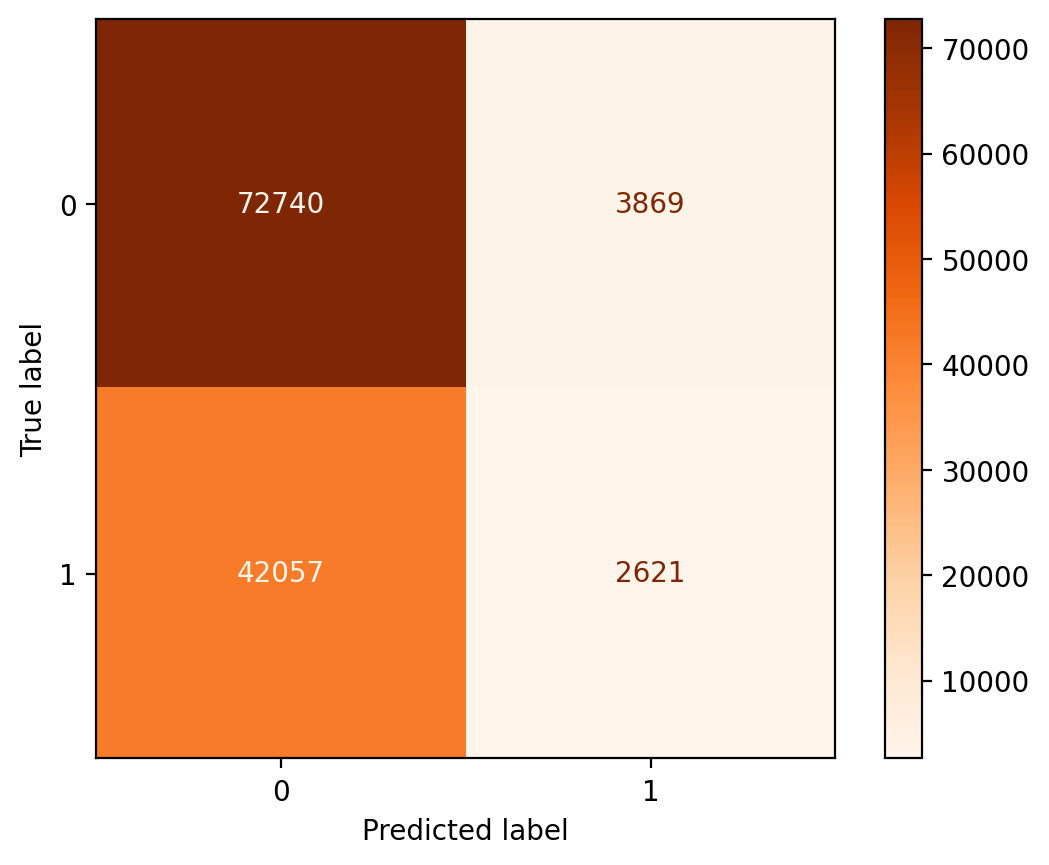

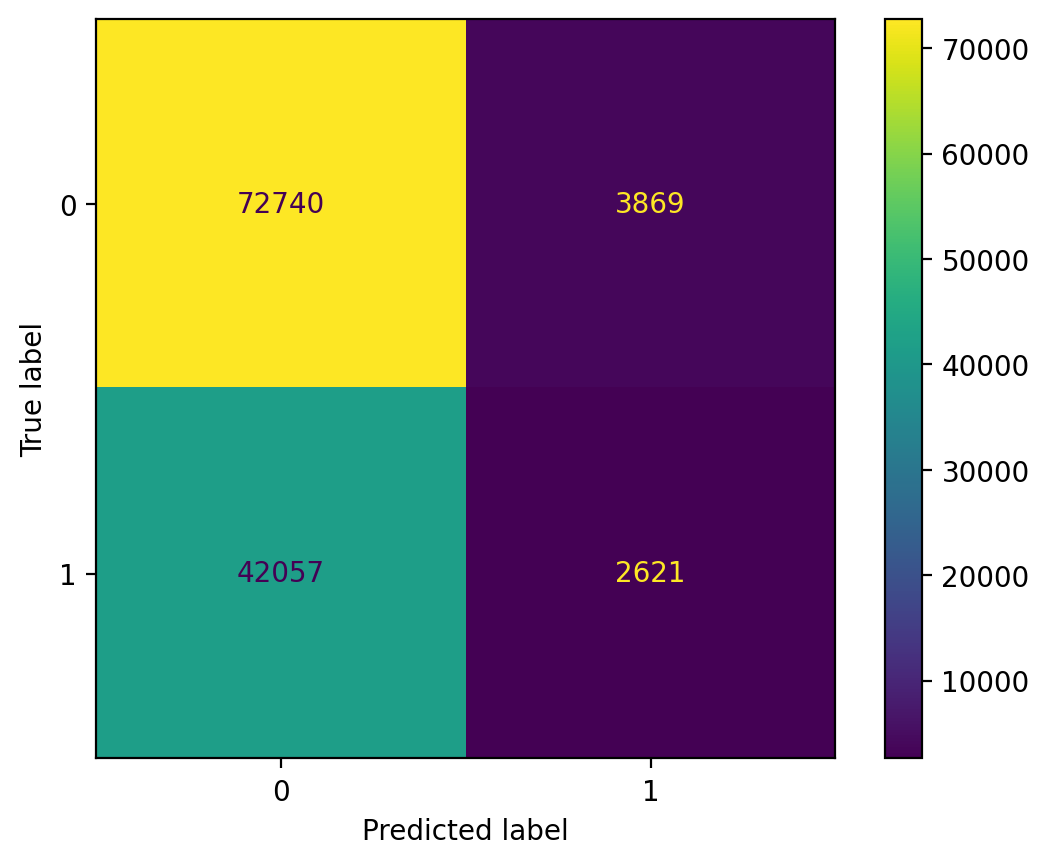

In [162]:
# Check confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Oranges')
matrix.plot()
plt.show()

### XGBoost + Word Counts

In [180]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Instantiate
xgb = XGBClassifier()

# Train the model
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:38:02] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [181]:
# Check accuracy
accuracy_score(y_test, y_pred)

0.6417093340588851

### Logistic Regression + TFIDF/SVD 

In [182]:
# split data into train and test 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    q_svd, y, test_size=0.3, random_state=42)

In [183]:
print(X_train.shape)
print(X_test.shape)

(283000, 200)
(121287, 200)


In [166]:
# Instantiate Classifier
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)

In [167]:
# Check accuracy
logreg.score(X_test, y_test)

0.7026391946375127

### XGBoost + TFIDF/SVD 

In [184]:
# Instantiate
xgb = XGBClassifier()

# Train the model
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:39:35] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [185]:
# Check accuracy
xgb.score(X_test, y_test)

0.7444078920247017

### LSTM

In [16]:
df.head(3)

,qid1,qid2,question1,question2,is_duplicate,q1_char_length,q2_char_length,q1_token,q2_token,q1_n_words,q2_n_words,q1_clean,q2_clean
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",7,6,step step guide invest share market india,step step guide invest share market
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,"[story, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",3,8,story kohinoor diamond,would happen indian government stole kohinoor ...
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",6,5,increase speed internet connection using vpn,internet speed increased hacking dns


In [32]:
# Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.backend import clear_session
from imblearn.under_sampling import RandomUnderSampler

In [18]:
y = df['is_duplicate']

In [19]:
# Use countvectorizer to create vocab 
from sklearn.feature_extraction.text import CountVectorizer

# Merge texts
questions = np.array(list(df['q1_clean'][:70000]) + list(df['q2_clean'][:70000]))

# Instantiate count vectorizer
cv = CountVectorizer(max_features=1500)

# Create vectors for each word, and then split the result
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [20]:
# Create a df for each vector matrix and combine them
vect_df1 = pd.DataFrame(q1_arr, index= df[:70000].index)
vect_df2 = pd.DataFrame(q2_arr, index= df[:70000].index)
vect_df = pd.concat([vect_df1, vect_df2], axis=1)
vect_df.shape

(70000, 3000)

In [21]:
# Create train and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    vect_df, y[:70000], test_size=0.25, random_state=42
)

In [22]:
print(X_train.shape)
print(y_train.shape)

(52500, 3000)
(52500,)


In [33]:
# Set input_dim to match no. of feats
input_dim = X_train.shape[1]

# Create Model
model = Sequential()

# Add layers
model.add(Dense(10, input_dim=input_dim, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

ValueError: Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 10)

In [28]:
# Compile and check overview
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30010     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 30,021
Trainable params: 30,021
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Train the model 
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=32)

Epoch 1/10


2022-11-18 17:10:26.632914: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1260000000 exceeds 10% of free system memory.


1641/1641 [==============================] - 3s 1ms/step - loss: 0.5850 - accuracy: 0.6977 - val_loss: 0.5556 - val_accuracy: 0.7214
Epoch 2/10
1641/1641 [==============================] - 2s 1ms/step - loss: 0.5357 - accuracy: 0.7343 - val_loss: 0.5522 - val_accuracy: 0.7238
Epoch 3/10
1641/1641 [==============================] - 2s 1ms/step - loss: 0.5143 - accuracy: 0.7470 - val_loss: 0.5497 - val_accuracy: 0.7259
Epoch 4/10
1641/1641 [==============================] - 2s 1ms/step - loss: 0.4951 - accuracy: 0.7609 - val_loss: 0.5506 - val_accuracy: 0.7266
Epoch 5/10
1641/1641 [==============================] - 2s 1ms/step - loss: 0.4781 - accuracy: 0.7708 - val_loss: 0.5519 - val_accuracy: 0.7259
Epoch 6/10
1641/1641 [==============================] - 2s 1ms/step - loss: 0.4616 - accuracy: 0.7826 - val_loss: 0.5559 - val_accuracy: 0.7249
Epoch 7/10
1641/1641 [==============================] - 2s 1ms/step - loss: 0.4458 - accuracy: 0.7920 - val_loss: 0.5608 - val_accuracy: 0.7239
Epo

In [27]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

2022-11-18 15:24:09.468443: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1260000000 exceeds 10% of free system memory.


Training Accuracy: 0.8567


2022-11-18 15:24:11.544572: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 420000000 exceeds 10% of free system memory.


Testing Accuracy:  0.7221


In [30]:
clear_session()

### Using Keras Processing

How can i feed a list of words, or vocabulary, to the model? Perhaps I could use text vectorizer? Use raw questions or tokenized questions?

https://www.tensorflow.org/text/tutorials/text_classification_rnn#setup_input_pipeline

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization